# Men's NCAA Basketball Tournament Predictions

## Download data from Kaggle

I used the Kaggle API to download the data. This requires an account in order to obtain an API key and to accept the terms and conditions of the [Google Cloud & Men's 2019 NCAA Tournament ML Competition](https://www.kaggle.com/c/mens-machine-learning-competition-2019/).

In [150]:
%%bash
kaggle competitions download -c mens-machine-learning-competition-2019

SampleSubmissionStage1.csv: Skipping, found more recently modified local copy (use --force to force download)













100%|██████████| 13.7M/13.7M [00:03<00:00, 5.51MB/s]
100%|██████████| 19.9M/19.9M [00:03<00:00, 5.96MB/s]
100%|██████████| 20.0M/20.0M [00:04<00:00, 5.08MB/s]
100%|██████████| 19.9M/19.9M [00:04<00:00, 4.50MB/s]
100%|██████████| 20.3M/20.3M [00:03<00:00, 5.38MB/s]
100%|██████████| 21.0M/21.0M [00:04<00:00, 5.34MB/s]
100%|██████████| 20.4M/20.4M [00:04<00:00, 5.20MB/s]
100%|██████████| 21.2M/21.2M [00:03<00:00, 6.00MB/s]
100%|██████████| 20.5M/20.5M [00:04<00:00, 4.71MB/s]
100%|██████████| 20.6M/20.6M [00:04<00:00, 4.58MB/s]
100%|██████████| 4.25M/4.25M [00:00<00:00, 4.56MB/s]


We care mostly about the files in ```DataFiles.zip```, so we will only unzip this directory. All the others contain information about play-by-play events. It would be really cool to incorporate individual player stats into a ML algorithm, but for now, I will only use team stats for each individual game.

In [1]:
import zipfile
zip_ref = zipfile.ZipFile('DataFiles.zip', 'r')
zip_ref.extractall('DataFiles')
zip_ref.close()

zip_ref = zipfile.ZipFile('MasseyOrdinals.zip','r')
zip_ref.extractall('MasseyOrdinals')
zip_ref.close()

I like to use Pandas to work with tabular data. There are two types of game-by-game data for the NCAA: compact results which give the simple box scores for each game (teamIDs, scores, and who was the home team or if the game was played at a neutral site) and detailed results with box scores along with all the statisics like field goal attempts/completions, etc. The former goes back all the way to 1985 and the latter only to 2003. We can use all the box scores dating back from 1985 to establish a long enough baseline to determine accurage Elo scores.

In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('DataFiles/RegularSeasonCompactResults.csv')
df1['Playoff'] = 0
df2 = pd.read_csv('DataFiles/NCAATourneyCompactResults.csv')
df2['Playoff'] = 1
df = pd.concat([df1,df2]).reset_index(drop=True)

In [2]:
df = df.sort_values(by=['Season','DayNum'])

In [3]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Playoff
0,1985,20,1228,81,1328,64,N,0,0
1,1985,25,1106,77,1354,70,H,0,0
2,1985,25,1112,63,1223,56,H,0,0
3,1985,25,1165,70,1432,54,H,0,0
4,1985,25,1192,86,1447,74,H,0,0


Elo scores were first developed for chess but have been adopted to predict outcomes of other games and sports. I have chosen to use the NBA Elo scores developed by [FiveThirtyEight](https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/).

We can calculate the probability of winning based on the Elo score difference between any two teams.

Elo scores are updated after a game occurs based on how surprising the outcome is. The larger the difference in the scores, the larger the expected point spread is. If the actual point differential is larger than expected, the more the Elo scores change. Elo scores are a zero-sum game, so points are added to the team who beats the point spread while points are taken from the other team.

At the end of the season, the Elo scores revert back toward the mean of 1500.

Not all the teams have been Division 1 since 1985, so we will have to add in the new teams at the beginning of the season. For that, we will need the data file indicating their first D1 season. Every team's first D1 season (starting with 1985) will have an Elo score of 1300. The next block of code propagates the Elo scores in chronological order.

In [38]:
def forecast(df,K,HCA,R,return_prob=False):
    start = time.time()
    prob_all = np.zeros(len(df))
    
    team_elo = {t:1300 for t in df['WTeamID'].unique()}
    season = 1985
    for i,game in df.iterrows():
        
        if game['Season'] > season:
            for team,elo in team_elo.items():
                if team_elo[team] != 1300:
                    team_elo[team] = 1505*R + elo*(1-R)
            season = game['Season']
        
        locW = game['WLoc']
        if locW == 'H':
            value = HCA
        elif locW == 'A':
            value = -HCA
        else:
            value = 0
        
        elo_diff = team_elo[game['WTeamID']]-team_elo[game['LTeamID']]+value
        probW = 1 / (10**(-elo_diff/400) + 1)  
        
        MOV = game['WScore']=game['LScore']
    
        mult = (MOV+3)**0.8 / (7.5 + 0.006*elo_diff)
    
        shift = K*mult*(1-probW)
        
        team_elo[game['WTeamID']] = team_elo[game['WTeamID']] + shift
        team_elo[game['LTeamID']] = team_elo[game['LTeamID']] - shift
        
        prob_all[i] = probW

    score = (prob_all > 0.5).sum()/len(prob_all)
    sumprob = prob_all.sum()/len(prob_all)
    end = time.time()
    
    dt = end-start
        
    if return_prob:
        return prob_all
    else:
        result = {'K':K,'HCA':HCA,'R':R,'score':score,'sumprob':sumprob}
        print('K=%d,HCA=%d,R=1/%d...score=%0.3f,sumprob=%0.3f...Elapsed Time: %0.1f sec' % (K,HCA,1/R,score,sumprob,dt))
        return result

The NBA Elo forecast from FiveThirtyEight used parameters K=20, HCA=100, R=1/3. The K factor determines how many elo points are transferred from the losing team to the winning team. HCA is the home court advantage, which gives extra Elo points to the home team. The R factor is how much the Elo scores revert back to the mean. For example, if a team had 1800 points at the end of the season, they would revert to 1700, subtract 1/3 of the difference from 1500.

We expect the NCAA to have similar values, but to be sure, we'll run the forecast with different parameters.

In [58]:
import time
import multiprocessing as mp

k = [20,30,40]
hca=[50,100,150]
r=[1/5,1/4,1/3]

start = time.time()
pool = mp.Pool(processes=4)
results = [pool.apply_async(forecast, args = (df,K,HCA,R)) \
           for K in k for HCA in hca for R in r]
output = [p.get() for p in results]

end = time.time()

t = (end-start)/60
print('Elapsed time: %0.1f min' % t)

K=20,HCA=50,R=1/5...score=0.713,sumprob=0.624...Elapsed Time: 24.6 sec
K=20,HCA=50,R=1/4...score=0.713,sumprob=0.622...Elapsed Time: 24.8 sec
K=20,HCA=50,R=1/3...score=0.713,sumprob=0.618...Elapsed Time: 24.7 sec
K=20,HCA=100,R=1/5...score=0.722,sumprob=0.637...Elapsed Time: 24.7 sec
K=20,HCA=100,R=1/4...score=0.722,sumprob=0.635...Elapsed Time: 27.4 sec
K=20,HCA=100,R=1/3...score=0.721,sumprob=0.631...Elapsed Time: 27.4 sec
K=20,HCA=150,R=1/5...score=0.722,sumprob=0.649...Elapsed Time: 27.5 sec
K=20,HCA=150,R=1/4...score=0.722,sumprob=0.646...Elapsed Time: 27.6 sec
K=20,HCA=150,R=1/3...score=0.720,sumprob=0.643...Elapsed Time: 27.4 sec
K=30,HCA=50,R=1/5...score=0.701,sumprob=0.630...Elapsed Time: 27.3 sec
K=30,HCA=50,R=1/4...score=0.701,sumprob=0.628...Elapsed Time: 27.3 sec
K=30,HCA=50,R=1/3...score=0.700,sumprob=0.625...Elapsed Time: 27.3 sec
K=30,HCA=100,R=1/5...score=0.713,sumprob=0.643...Elapsed Time: 25.5 sec
K=30,HCA=100,R=1/4...score=0.712,sumprob=0.641...Elapsed Time: 25.7 se

Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Process ForkPoolWorker-15:
Process ForkPoolWorker-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/anaconda3/lib/python3

In [59]:
elo_df = pd.DataFrame(output)

In [68]:
elo_df[elo_df['score'] == elo_df['score'].max()]

,HCA,K,R,score,sumprob
3,100,20,0.2,0.722454,0.637451


In [69]:
prob = forecast(df,20,100,0.2,return_prob=True)

In [70]:
df['Elo_Prob'] = prob

## Game statistics

In [236]:
data1 = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
data1['Playoff'] = 0
data2 = pd.read_csv('DataFiles/NCAATourneyDetailedResults.csv')
data2['Playoff'] = 1
data = pd.concat([data1,data2])
data = data.sort_values(by=['Season','DayNum'])

In [237]:
data.head(10)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,Playoff
0,2003,10,1104,68,1328,62,N,0,27,58,...,16,22,10,22,8,18,9,2,20,0
1,2003,10,1272,70,1393,63,N,0,26,62,...,9,20,20,25,7,12,8,6,16,0
2,2003,11,1266,73,1437,61,N,0,24,58,...,14,23,31,22,9,12,2,5,23,0
3,2003,11,1296,56,1457,50,N,0,18,38,...,8,15,17,20,9,19,4,3,23,0
4,2003,11,1400,77,1208,71,N,0,30,61,...,17,27,21,15,12,10,7,1,14,0
5,2003,11,1458,81,1186,55,H,0,26,57,...,12,17,6,22,8,19,4,3,25,0
6,2003,12,1161,80,1236,62,H,0,23,55,...,20,28,9,21,11,30,10,4,28,0
7,2003,12,1186,75,1457,61,N,0,28,62,...,17,23,8,25,10,15,14,8,18,0
8,2003,12,1194,71,1156,66,N,0,28,58,...,12,27,13,26,13,25,8,2,18,0
9,2003,12,1458,84,1296,56,H,0,32,67,...,7,12,9,23,10,18,1,3,18,0


In [238]:
data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Playoff'],
      dtype='object')

Here are the statistics for each game since 2003.
- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

And the same for the losing teams with an "L" in front.

Let's append the Elo scores and probabilities to this new table.

In [239]:
df_short = df[df['Season'] >= 2003].reset_index(drop=True)
data = pd.merge(df_short,data)

Right now, the Elo scores are a good measure of the historical performance of a basketball program; however, game stats will help us to determine how a team has been performing as of late. We'll do this by taking a rolling average of some of the statistics over previous games. We have to be careful to not include the current game stats in this average because it will help to reveal the outcome of the game, which we are trying to predict.

In [240]:
## Here are the statistics we want to create rolling means for
to_roll = ['FGM','FGA','FGM3','FGA3']

## We're going to create a dictionary of dictionaries that store the rolling means for each team.
##    The outer dictionary is for each individual team.
##    The inner dictionaries contain each statistic's rolling mean.
averages = dict()
for ID in data['WTeamID'].unique():
    averages[ID] = dict()
    team = data[(data['WTeamID'] == ID) | (data['LTeamID'] == ID)]
    for r in to_roll:
        ## Here we apply a function that selects the correct statistic based on whether the team is W or L.
        ## Method chaining: roll over last 4 games, take the mean, shift one down so that we don't include
        ##     the statistic for the game that is being predicted, backward fill for NaN
        averages[ID][r] = team.apply(lambda x: x['W%s' % r] if x['WTeamID'] == 1104 else x['L%s' % r],axis=1).\
            rolling(4).mean().shift(1).bfill()

The predictors we use for our comprehensive algorithm will be the difference of the winning team's statistic to that the losing team.

In [241]:
for r in to_roll:
    win = data.apply(lambda row: averages[row['WTeamID']][r].loc[row.name],axis=1)
    los = data.apply(lambda row: averages[row['LTeamID']][r].loc[row.name],axis=1)
    data[r] = win-los

## Rankings

We have a compilation of rankings for each team given provided by Kenneth Massey going back to 2003. The effective date of the ranking is chosen so that predictions made based on those rankings can be made on that day.

I'll choose an approach based on how election polling reports go where we will use a rolling average in order to determine the effective rating of a team on a given day.

In order to do this in Pandas, we need to convert the ```Season,DayNum``` pairs into true dates. Luckily, we have also been given a file that gives day zero for every season.

In [242]:
rankings = pd.read_csv('MasseyOrdinals/MasseyOrdinals.csv')
rankings.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [243]:
seasons = pd.read_csv('DataFiles/Seasons.csv',parse_dates=['DayZero'],index_col='Season')
seasons.head()

,DayZero,RegionW,RegionX,RegionY,RegionZ
Season,,,,,
1985,1984-10-29,East,West,Midwest,Southeast
1986,1985-10-28,East,Midwest,Southeast,West
1987,1986-10-27,East,Southeast,Midwest,West
1988,1987-11-02,East,Midwest,Southeast,West
1989,1988-10-31,East,West,Midwest,Southeast


Now, let's use both data frames to add a column to rankings that is the date of the released rankings.

In [249]:
rankings['Date'] = rankings.apply(lambda row: pd.to_timedelta(row['RankingDayNum'],unit='D') + \
                                  seasons.loc[row['Season'],'DayZero'],axis=1)    

Let's resample the rankings for each team by week and take a mean of the rankings. For the weeks when no rankings are available, we will interpolate the ranking value.

In [227]:
## save this in a dictionary with team ID as key
eff_rank = {t:rankings[rankings['TeamID'] == t].set_index('Date').resample('7D').mean().interpolate()['OrdinalRank'] \
               for t in rankings['TeamID'].unique()}

Now we need to match the ranks of the winning and losing teams in the main data frame.

In [251]:
data['Date'] = data.apply(lambda row: pd.to_timedelta(row['DayNum'],unit='D') \
                          + seasons.loc[row['Season'],'DayZero'],axis=1)

In [268]:
for i,game in data.iterrows():
    Wteam_rank = eff_rank[game['WTeamID']].reset_index()
    Widx = (Wteam_rank['Date'] - game['Date']).abs().idxmin()
    data.at[i,'Wrank'] = Wteam_rank.loc[Widx,'OrdinalRank']
    Lteam_rank = eff_rank[game['LTeamID']].reset_index()
    Lidx = (Lteam_rank['Date'] - game['Date']).abs().idxmin()
    data.at[i,'Lrank'] = Lteam_rank.loc[Lidx,'OrdinalRank']

In [269]:
data['RankDiff'] = data['Wrank'] - data['Lrank']

In [270]:
data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Playoff,Elo_Prob,...,LBlk,LPF,FGM,FGA,FGM3,FGA3,Date,Wrank,Lrank,RankDiff
0,2003,10,1104,68,1328,62,N,0,0,0.513058,...,2,20,-1.00,4.75,1.0,4.75,2002-11-14,14.157895,22.157895,-8.000000
1,2003,10,1272,70,1393,63,N,0,0,0.557257,...,6,16,-2.75,-6.50,-0.5,-3.25,2002-11-14,66.764706,76.823529,-10.058824
2,2003,11,1266,73,1437,61,N,0,0,0.379978,...,5,23,2.75,4.50,1.5,1.25,2002-11-15,29.210526,42.411765,-13.201238
3,2003,11,1296,56,1457,50,N,0,0,0.959246,...,3,23,0.25,2.50,-1.5,-0.25,2002-11-15,179.764706,231.176471,-51.411765
4,2003,11,1400,77,1208,71,N,0,0,0.808446,...,1,14,-6.50,-5.50,-2.0,-4.50,2002-11-15,17.263158,63.764706,-46.501548


## Prepping for ML

The data came to us without a "target" value, as the first team listed is always the winning team, we have to create our own. One way would be to randomly split the data in two and for half the data swap the teams. If the winning team is in the first column, the target is 1, or else it is 0. Of course, in doing this, we also have to reverse the predictor values to reflect the change.

In [271]:
## shuffle the data by re-sampling all of it
data_shuffle = data.sample(frac=1,random_state=123)

## split the shuffled data in two
orig = data_shuffle.iloc[:len(data)//2,:]
rev = data_shuffle.iloc[len(data)//2:,:]

## reverse the values in the second half of the data
for r in to_roll:
    temp = -rev[r]
    rev = rev.drop(columns=r)
    rev[r] = temp
    
new_prob = 1-rev['Elo_Prob']
rev = rev.drop(columns=['Elo_Prob'])
rev['Elo_Prob'] = new_prob

new_rank = -rev['RankDiff']
rev = rev.drop(columns=['RankDiff'])
rev['RankDiff'] = new_rank

## order columns in rev
rev = rev[orig.columns]
orig = orig[orig.columns]

## Add columns for the target values
orig['result'] = 1
rev['result'] = 0

## Merge the two back together
data_target = pd.concat([orig,rev])
data_target = data_target.sort_values(by=['Season','DayNum'])

In [272]:
predictors = to_roll + ['Elo_Prob','RankDiff']

In [273]:
X = data_target[predictors]
y = data_target['result']

In [274]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

In [275]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(GradientBoostingClassifier(random_state=123),
                   param_grid = {'n_estimators':[100,200,300],
                                'min_samples_split':[2,3,4],
                                'max_depth':[3,4,5]})
grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300], 'min_samples_split': [2, 3, 4], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [276]:
clf = grid.best_estimator_

In [277]:
print('Train score: %0.2f' % clf.score(X_train,y_train))
print('Test score:  %0.2f' % clf.score(X_test,y_test))

Train score: 0.82
Test score:  0.82


In [278]:
clf.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'presort': 'auto',
 'random_state': 123,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

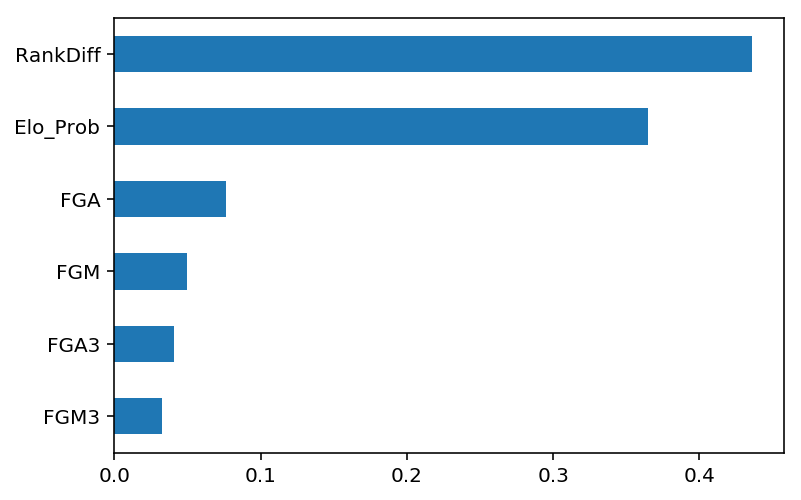

In [279]:
%matplotlib inline
pd.DataFrame(clf.feature_importances_,index=X.columns).sort_values(by=0).plot(kind='barh',legend=False)